In [14]:
%load_ext autoreload
%autoreload 2

import os
import sys
import cv2
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osgeo import gdal
from matplotlib import patches as mpl_patches
from matplotlib.colors import Colormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering, AffinityPropagation

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline import load as pipeline
from reproduction.analysis import (
    AEData, plot_cluster_channel_distributions, plot_cluster_samples, plot_all_cluster_samples,
    get_tif_metadata
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model_dir = "../experimental/mod09cnn8-4km/"

with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")

In [16]:
SHAPE = 64, 64, 7

# Clustering one example swath

In [17]:
swath_tif = gdal.Open("../data/tif/2017-01-31_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000000000-0000052992.tif")

17664 17664


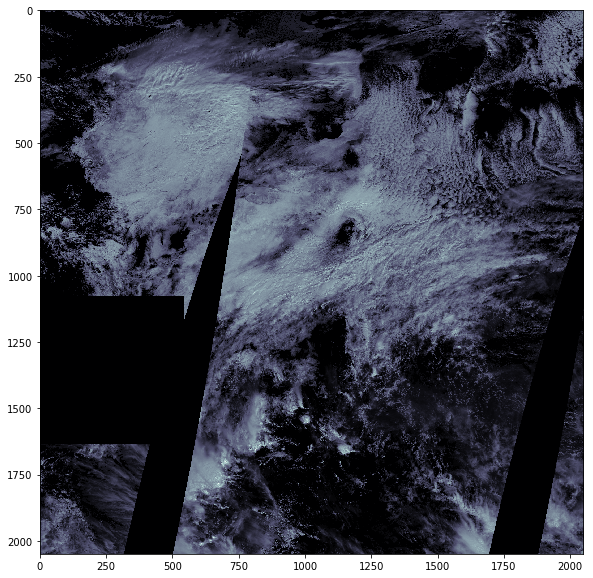

In [65]:
%matplotlib inline
swath = gdal.Open("../data/tif/2017-01-31_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000000000-0000052992.tif")
print(swath.RasterYSize, swath.RasterYSize)
swath = swath.ReadAsArray(xoff=9400, yoff=4600, xsize=8196, ysize=8196)
swath = np.rollaxis(swath, 0, 3)
swath = cv2.resize(swath, dsize=None, fx=0.25, fy=0.25)
plt.figure(figsize=(10, 10))
plt.imshow(swath[:,:,0], cmap="bone")

In [69]:
swath_mean = swath.mean(axis=(0,1))
swath_std = swath.std(axis=(0,1))
patches = []

stride = 64
patch_size = 64

patches = []
for i in range(0, swath.shape[0], stride):
    row = []
    for j in range(0, swath.shape[1], stride):
        if i + patch_size < swath.shape[0] and j + patch_size < swath.shape[1]:
            p = swath[i:i + patch_size, j:j + patch_size].astype(float)
            p -= swath_mean
            p /= swath_std
            
            row.append(p)
    if row:
        patches.append(row)
            
patches = np.stack(patches)
patches.shape

(32, 32, 64, 64, 7)

In [70]:
_encs, _ = ae.predict(patches.reshape((-1, *SHAPE)))
# color_map = ["c%d"%i for i in range(10)]
# color_map = plt.cm.tab10

In [172]:
method = SpectralClustering(8, affinity="rbf")
# method = AffinityPropagation()
features = _encs.mean(axis=(1,2))

In [173]:
patches_labels = method.fit_predict(features).reshape(patches.shape[:2])

In [174]:
colors = plt.cm.Dark2(patches_labels)
# colors = plt.cm.gist_rainbow(patches_labels / patches_labels.max())
# colors = ["blue", "green", "cyan", "magenta", "yellow", "orange", "black"]

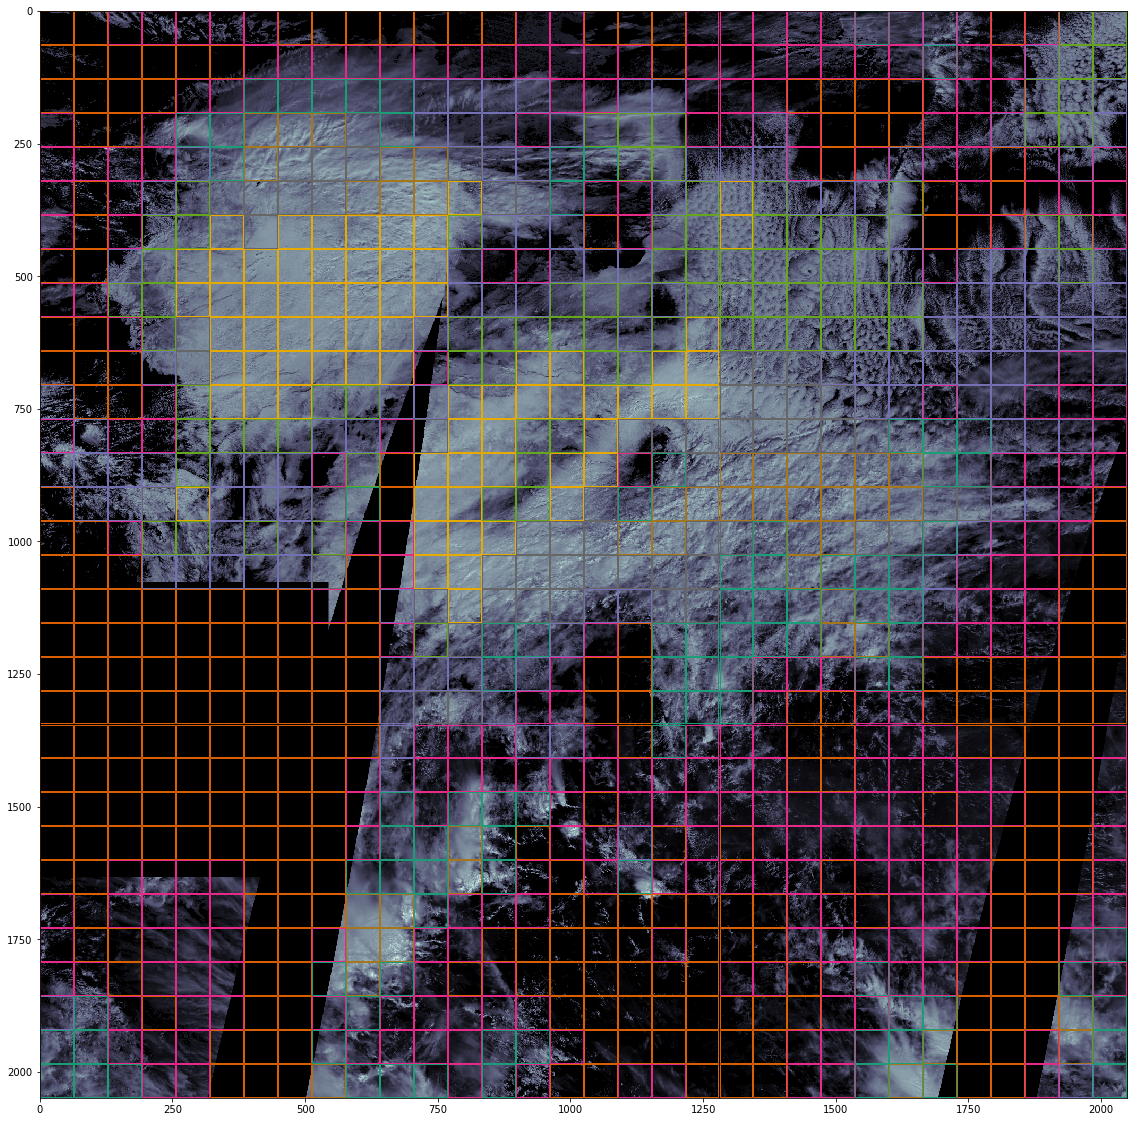

In [175]:
%matplotlib inline
line_width = 1

fig, a = plt.subplots(figsize=(20,20))
plt.imshow(swath[:,:,0], cmap="bone")
rects = []
for i in range(colors.shape[0]):
    for j in range(colors.shape[1]):
        a.add_patch(mpl_patches.Rectangle(
            (i * SHAPE[0] + line_width, j * SHAPE[1] + line_width),
            width=SHAPE[0] - line_width * 2,
            height=SHAPE[1] - line_width * 2,
            linewidth=line_width,
            edgecolor=colors[j,i],
            facecolor="none"
        ))

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(*patches.shape[:2], figsize=[x*2 for x in patches.shape[:2]])

# Need to use 1 normalization for all patches so its visually consistent with whole swath plot
normalization = plt.Normalize(vmin=patches[:,:,:,:,0].min(), vmax=patches[:,:,:,:,0].max())

for i, row in enumerate(patches):
    for j, patch in enumerate(row):
        a = ax[i,j]
        label = patches_labels[i,j]
        a.imshow(
            patches[i, j, :, :, 0],
            cmap="bone",
            norm=normalization
        )
        plt.setp(a.spines.values(), color=colors, linewidth=3)
        a.set_xticks([])
        a.set_yticks([])

plt.tight_layout(pad=-.3) 

# Clustering many random patches

In [ ]:
data = AEData(
    dataset=pipeline.load_data(
        data_glob="../data/tif/*.tfrecord",
        shape=SHAPE,
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2,
        flips=False
    ),
    ae=ae,
    fields=["b%d"%(i+1) for i in range(7)],
    n=3000
)

In [ ]:
def clusterfy(labels):
    n_clusters = len(set(labels))
    clusters = [set() for _ in range(n_clusters)]
    for i, l in enumerate(labels):
        clusters[l].add(i)
    return clusters

def jaccard_similarity(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

In [ ]:
n_clusters = 40
sc = SpectralClustering(n_clusters, affinity="rbf").fit(data.pca_project(data, d=100).T)
km = KMeans(n_clusters).fit(data.pca_project(data, d=100).T)

In [ ]:
%matplotlib inline
fig, (a, b, c) = plt.subplots(ncols=3, figsize=(15,5))
a.hist(sc.labels_)
a.set_title("spectral clustering cluster sizes")
c.hist(km.labels_);
c.set_title("kmeans clustering cluster sizes")

c1s = clusterfy(sc.labels_)
c2s = clusterfy(km.labels_)
# c1s, c2s = np.random.randint(0, high=70, size=(2, 3000), dtype=np.int32)
# c1s, c2s = clusterfy(c1s), clusterfy(c2s)

jsims = np.zeros((len(c1s), len(c2s)))
for i, c1 in enumerate(c1s):
    for j, c2 in enumerate(c2s):
        jsims[i, j] =  jaccard_similarity(c1, c2)
        
b.set_ylabel("spectral clusters")
b.set_xlabel("k-means clusters")
b.set_title("Jaccard similarity")
b.imshow(jsims, cmap="bone", norm=plt.Normalize(vmin=0, vmax=1));

In [ ]:
#fig, ax = plot_cluster_channel_distributions(data.imgs, km.labels_)

In [ ]:
fig, ax = plot_cluster_samples(data.imgs, sc.labels_, samples=20)

In [ ]:
fig, ax = plot_cluster_samples(data.imgs, km.labels_, samples=20)

In [ ]:
features = data.pca_project(data, d=100).T
ag = sklearn.cluster.AgglomerativeClustering(
    n_clusters=50,
    connectivity=sklearn.neighbors.kneighbors_graph(features, 20)
).fit_predict(features)

In [ ]:
# fig, _ = plot_all_cluster_samples(data.imgs.mean(axis=3), ag)
# fig.savefig("ag_clusters.png")

In [ ]:
#fig, ax = plot_cluster_samples(data.imgs, ag, samples=20)

In [ ]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib notebook

# fig = plt.figure(figsize=(10,10))

# ax = fig.add_subplot(1,1,1, projection="3d")
# ax.scatter(*data.pca_project(data), c=ag)

In [ ]:
ap = sklearn.cluster.AffinityPropagation(damping=.5)
ap.fit(data.encs)

In [ ]:
np.unique(np.unique(ap.labels_, return_counts=True)[1], return_counts=True)

In [ ]:
# fig, ax = plot_cluster_samples(data.imgs, ap, samples=5)

In [ ]:
import scipy as sp

In [ ]:
fc = sp.cluster.hierarchy.fclusterdata(data.encs, 0.3, criterion="distance")
uniq, counts = np.unique(fc, return_counts=True)

In [ ]:
np.unique(counts, return_counts=True)

In [ ]:
# plot_cluster_samples(data.imgs, fc, samples=10)

In [ ]:
# %matplotlib inline
# plt.figure(figsize=(10, 360))
# plt.imshow(data.imgs[ap.labels_ == 0].reshape((-1, 128, 7)).mean(axis=2))
# plt.savefig("foo.png")

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection="3d")
ax.scatter(*data.pca_project(data), c=sc.labels_);

In [ ]:
sc.labels_.shape

In [ ]:
data.names[0]

In [ ]:
g = b'/Users/casperneo/work/cloud-research/clouds/data/tif/2017-01-08_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000000000-0000070656.tif'

In [ ]:
n = np.array([g[2:-1] for g in data.names])

In [ ]:
n[0]

In [ ]:
type(data.coords.astype(np.int32)[0,0])

In [ ]:
swath = gdal.Open(data.names[4])

In [ ]:
swath.RasterXSize

In [ ]:
def open_neighborhood(fname, coord, shape, context_width=128):
    yoff, xoff = coord
    xsize, ysize = shape
    
    # Estimate LatLon of the patch linearly ignoring geodesic effects
    xpct, ypct = xoff / xsize, yoff / ysize
    m = get_tif_metadata(fname)
    lon0, lat0 = m.cornerCoordinates.upperLeft
    lon1, lat1 = m.cornerCoordinates.lowerRight
    lon = xpct * lon0 + (1 - xpct) * lon1
    lat = xpct * lat0 + (1 - xpct) * lat1
    
    # Open patch plus context_width more pixels to every side
    def rebox(off, size, mx):
        l_most = max(off - context_width, 0)
        r_most = min(mx, off + size + context_width)
        new_size = r_most - l_most
        return map(int, [l_most, new_size, off - l_most])
        
    swath = gdal.Open(data.names[i])
    xoff, xsize, left = rebox(xoff, xsize, swath.RasterXSize)
    yoff, ysize, top = rebox(yoff, ysize, swath.RasterYSize)
    p = swath.ReadAsArray(xoff, yoff, xsize, ysize)
    
    return p, (left, top), (lat, lon)


In [ ]:
%matplotlib inline

nsamples = 20
width=5

fig, ax = plt.subplots(nsamples, 2, figsize=(2 * width, nsamples * width))

for row, i in enumerate(np.where(sc.labels_ == 27)[0][:nsamples]):
    channel = 0
    context_width = 500

    p, orig, latlon = open_neighborhood(
        data.names[i],
        data.coords[i],
        data.imgs.shape[1:3],
        context_width
    )
    
    a, b = ax[row]
    a.imshow(data.imgs[i,:,:, channel], cmap="bone")
    b.imshow(p[channel], cmap="bone") 
    b.add_patch(
        mpl_patches.Rectangle(
            orig,
            *data.imgs.shape[1:3],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
    )
    
    b.set_title(latlon)

In [ ]:
np.where(sc.labels_ == 7)